In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
os.environ["OMP_NUM_THREADS"] = "4"
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats


In [2]:
# read preprocessed data
#data = pd.read_csv("data/preprocessedData.csv")
data = pd.read_csv("data/reducedData.csv")

data = data.drop('Unnamed: 0', axis=1)  
data = data.iloc[:1000]
# separate the predictors and the criterion variable
trainCrit = data['Heart_Disease']  
#data = data.drop('Heart_Disease', axis=1)  


In [3]:
data

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,BMI,Smoking_History,Alcohol_Consumption
0,1,4,0,0,0,0,0,0,1,1,72,14.54,1,0.0
1,4,5,0,1,0,0,0,1,0,1,72,28.29,0,0.0
2,4,5,1,0,0,0,0,1,0,1,62,33.47,0,4.0
3,1,5,1,1,0,0,0,1,0,0,77,28.73,0,0.0
4,3,5,0,0,0,0,0,0,0,0,82,24.37,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,5,1,0,0,0,0,0,0,1,47,26.58,1,0.0
996,4,5,0,0,0,0,1,0,0,0,42,31.75,0,0.0
997,3,3,1,0,0,0,0,0,0,0,57,28.75,1,12.0
998,4,5,1,0,0,0,0,0,0,0,27,21.91,0,7.0


## PCA

[0.58912315 0.4361538  0.45762552 0.46569219 0.41433189 0.40750273
 0.57721798 0.43161767 0.45364895 0.28933951 0.84261684 0.62609306
 0.11301082 0.41702516]
                Feature  Importance
10         Age_Category    0.129216
11                  BMI    0.096012
0        General_Health    0.090342
6            Depression    0.088517
3         Heart_Disease    0.071414
2              Exercise    0.070177
8             Arthritis    0.069567
1               Checkup    0.066885
7              Diabetes    0.066189
13  Alcohol_Consumption    0.063951
4           Skin_Cancer    0.063538
5          Other_Cancer    0.062491
9                   Sex    0.044370
12      Smoking_History    0.017330


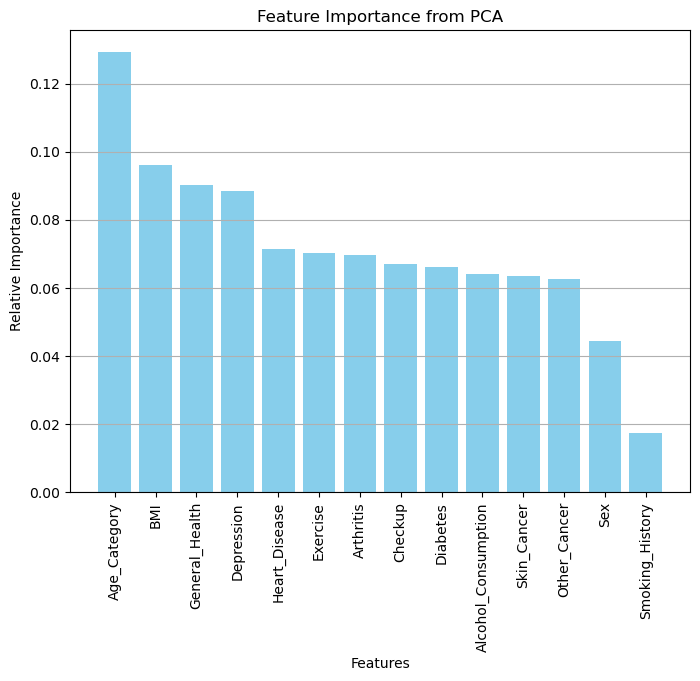

In [4]:
# scale data, so that all variables contribute equally
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA, get 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

components = np.abs(pca.components_)  # Absolute value of eigenvectors
print(components.sum(axis=0))

# Compute total importance of each feature
feature_importance = components.sum(axis=0)
# Normalize importance (optional)
feature_importance_normalized = feature_importance / feature_importance.sum()
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': data.columns,
    'Importance': feature_importance_normalized
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from PCA')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

[[0.47808152 0.22260359 0.30791671 0.27753306 0.07465023 0.16920897
  0.1719646  0.34057817 0.41146858 0.07859766 0.30395794 0.22346241
  0.05467546 0.22243985]
 [0.11174749 0.21121917 0.14760535 0.18798008 0.33863188 0.2378083
  0.40237813 0.08846029 0.04552306 0.2163483  0.53751962 0.40558377
  0.05676955 0.19821739]]
                Feature  Importance
0        General_Health    0.143261
8             Arthritis    0.123300
7              Diabetes    0.102057
2              Exercise    0.092270
10         Age_Category    0.091083
3         Heart_Disease    0.083165
11                  BMI    0.066962
1               Checkup    0.066705
13  Alcohol_Consumption    0.066656
6            Depression    0.051531
5          Other_Cancer    0.050705
9                   Sex    0.023552
4           Skin_Cancer    0.022370
12      Smoking_History    0.016384


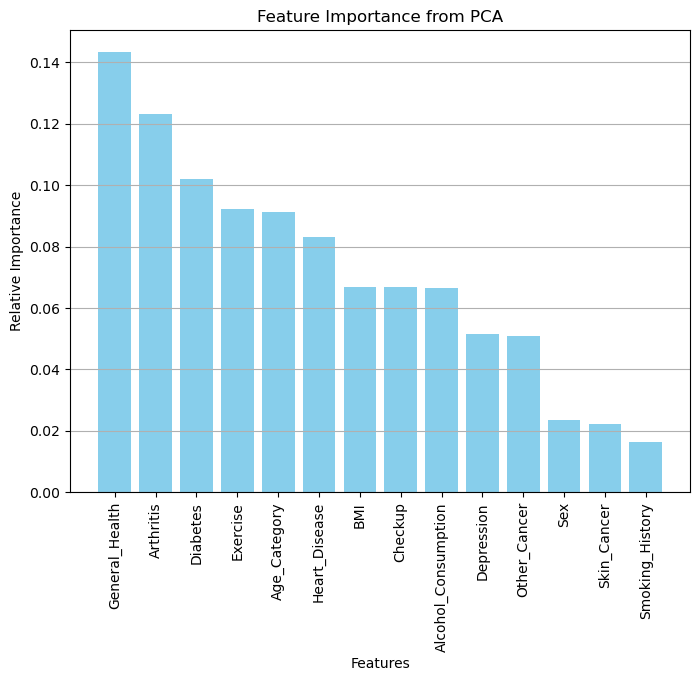

In [5]:
# scale data, so that all variables contribute equally
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA, get 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

components = np.abs(pca.components_)  # Absolute value of eigenvectors
print(components)

# Compute total importance of each feature
feature_importance = components[0]
# Normalize importance (optional)
feature_importance_normalized = feature_importance / feature_importance.sum()
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': data.columns,
    'Importance': feature_importance_normalized
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from PCA')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

[[0.47867149 0.22262898 0.30786577 0.27774546 0.07521284 0.16933451
  0.17179712 0.340714   0.41087856 0.07936658 0.30369098 0.22370604
  0.05466436 0.22152563]
 [0.1094839  0.21277375 0.15034397 0.18723347 0.33894873 0.23706003
  0.40566944 0.09091959 0.04525229 0.21311398 0.53756408 0.40459183
  0.05593563 0.19467753]]
                Feature  Importance
10         Age_Category    0.168856
6            Depression    0.127426
11                  BMI    0.127088
4           Skin_Cancer    0.106468
5          Other_Cancer    0.074464
9                   Sex    0.066942
1               Checkup    0.066835
13  Alcohol_Consumption    0.061151
3         Heart_Disease    0.058812
2              Exercise    0.047225
0        General_Health    0.034390
7              Diabetes    0.028559
12      Smoking_History    0.017570
8             Arthritis    0.014214


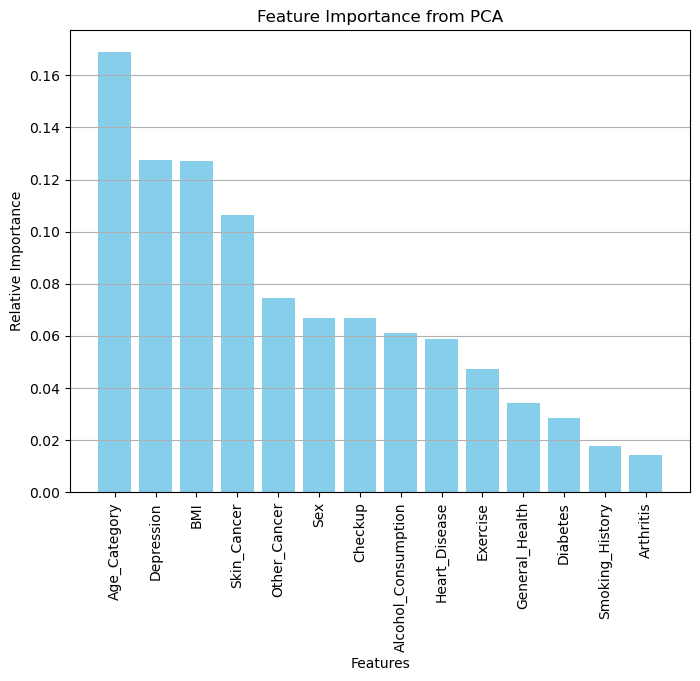

In [6]:
# scale data, so that all variables contribute equally
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA, get 2 principal components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

components = np.abs(pca.components_)  # Absolute value of eigenvectors
print(components)

# Compute total importance of each feature
feature_importance = components[1]
# Normalize importance (optional)
feature_importance_normalized = feature_importance / feature_importance.sum()
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': data.columns,
    'Importance': feature_importance_normalized
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from PCA')
plt.xlabel('Features')
plt.ylabel('Relative Importance')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

## 1. K-means algorithm

### Find out the best k for k-means using the "elbow method"

In [7]:
data_kmeans = data.copy()
data_kmeans = data_kmeans.apply(lambda x: (x - x.min()) / (x.max() - x.min())) # Normalize the data
data_kmeans

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,BMI,Smoking_History,Alcohol_Consumption
0,0.00,0.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.836066,0.012715,1.0,0.000000
1,0.75,1.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.836066,0.376954,0.0,0.000000
2,0.75,1.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.672131,0.514172,0.0,0.133333
3,0.00,1.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.918033,0.388609,0.0,0.000000
4,0.50,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.273113,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.00,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.426230,0.331656,1.0,0.000000
996,0.75,1.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.344262,0.468609,0.0,0.000000
997,0.50,0.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.590164,0.389139,1.0,0.400000
998,0.75,1.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098361,0.207947,0.0,0.233333


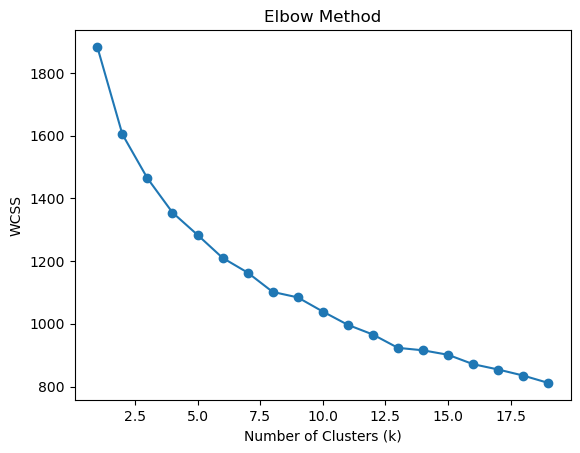

In [8]:
wcss = [] # wcss = Within-Cluster Sum of Squares, measures total variance within each cluster, which we aim to minimize
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # 10 rounds repeat (since performance dependend on random first centers)
    kmeans.fit(data_kmeans)
    wcss.append(kmeans.inertia_) # inertia is wcss for specific k
    
plt.plot(range(1, 20), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [9]:
# The optimal point for k seems to be k=3
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# Fit the model
kmeans.fit(data_kmeans)
# Get the cluster assignments
y_kmeans = kmeans.predict(data_kmeans)
data_kmeans['Cluster assignment'] = y_kmeans

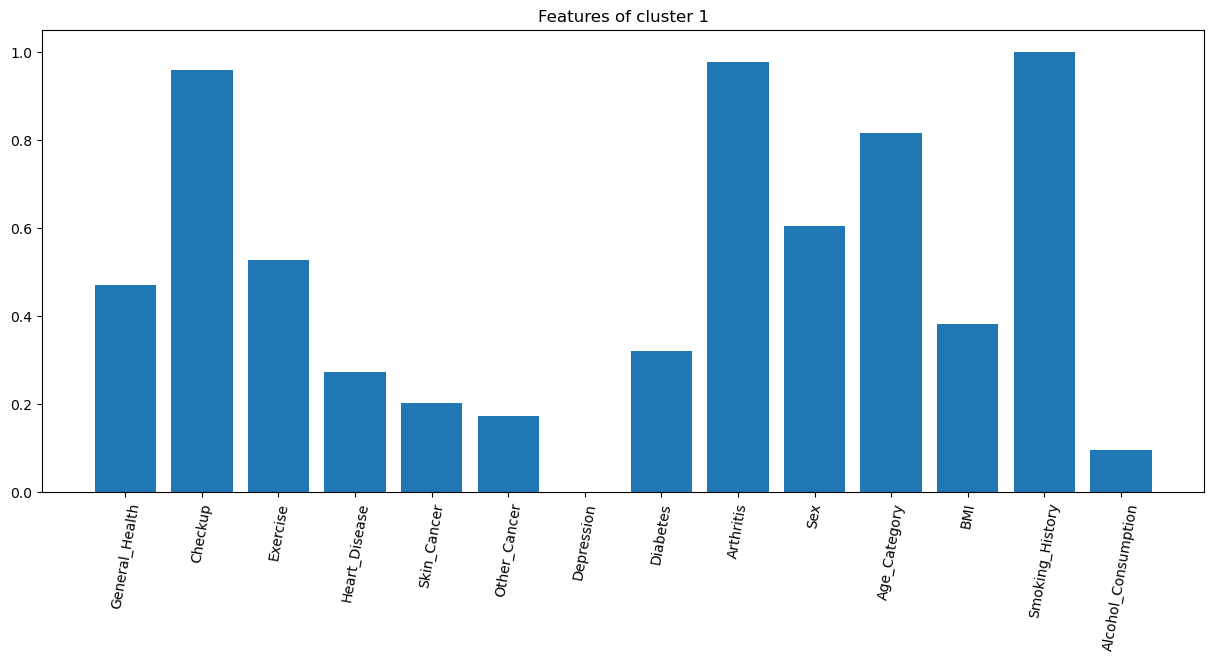

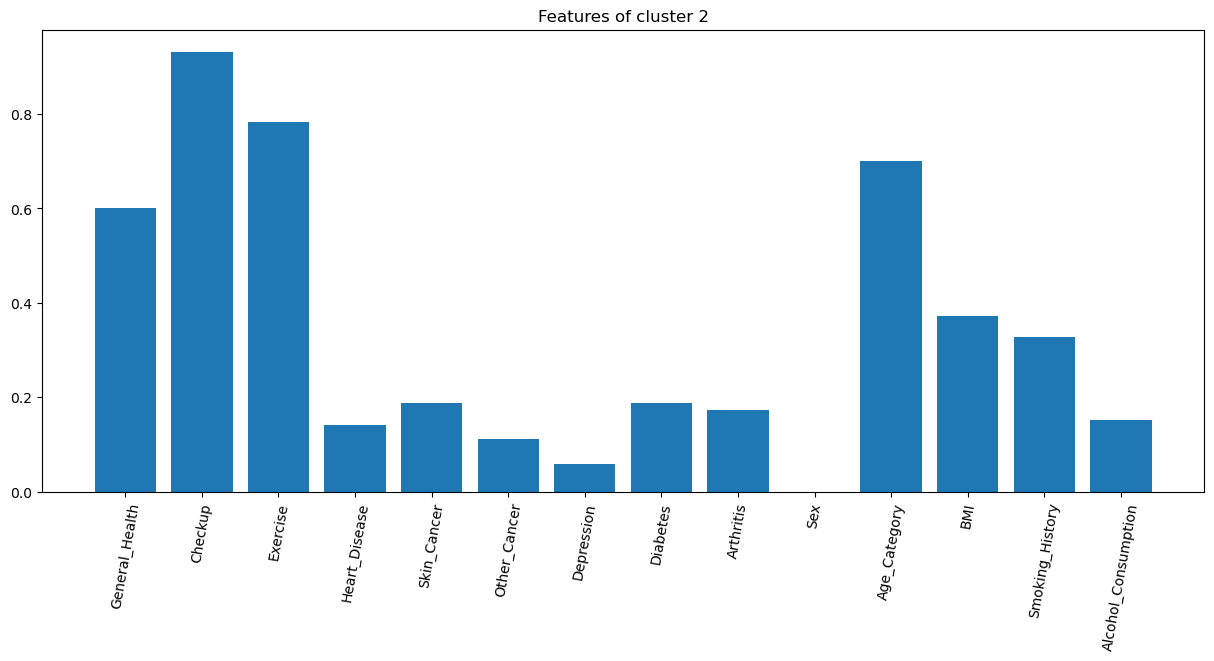

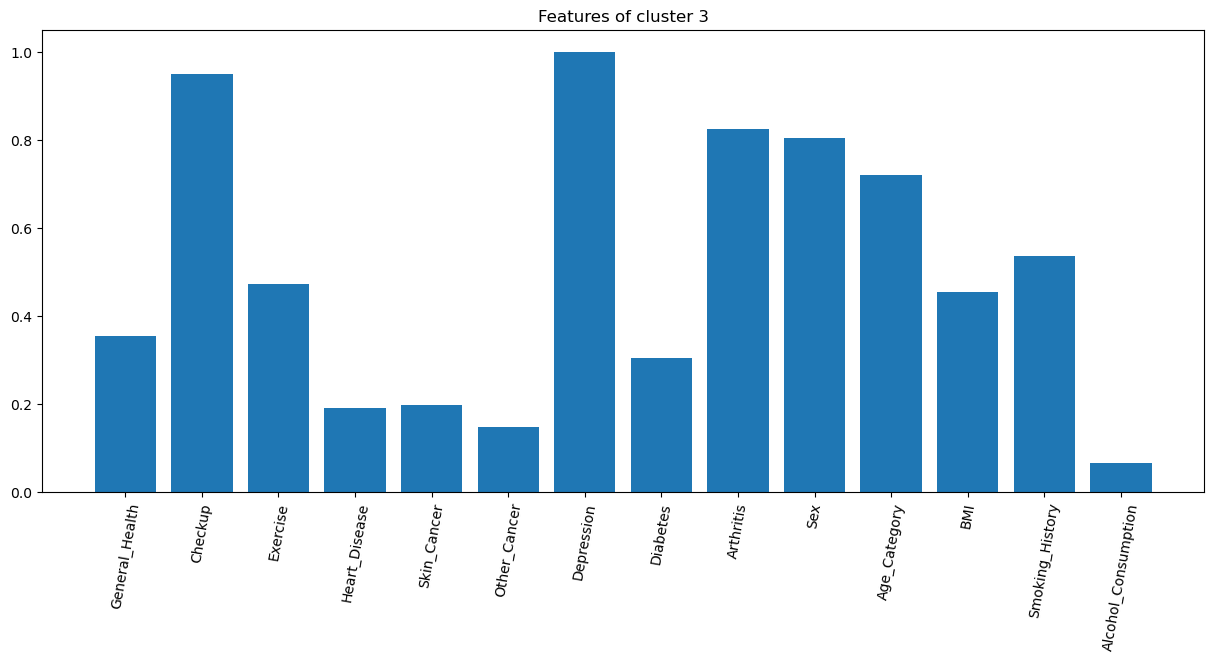

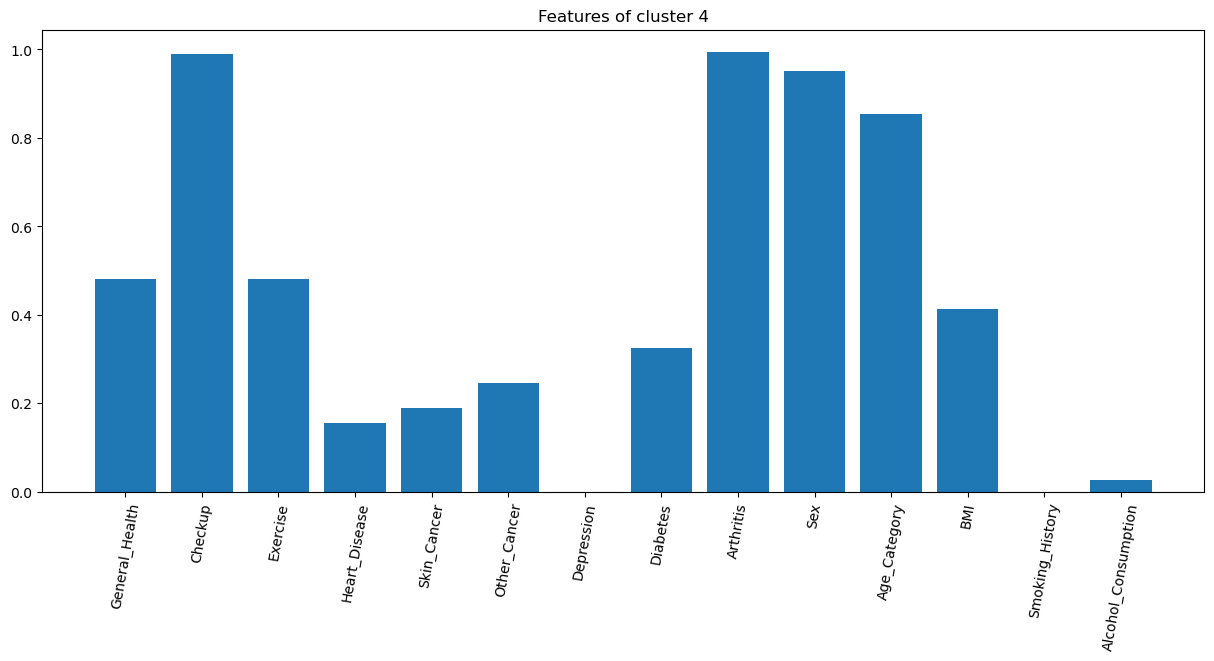

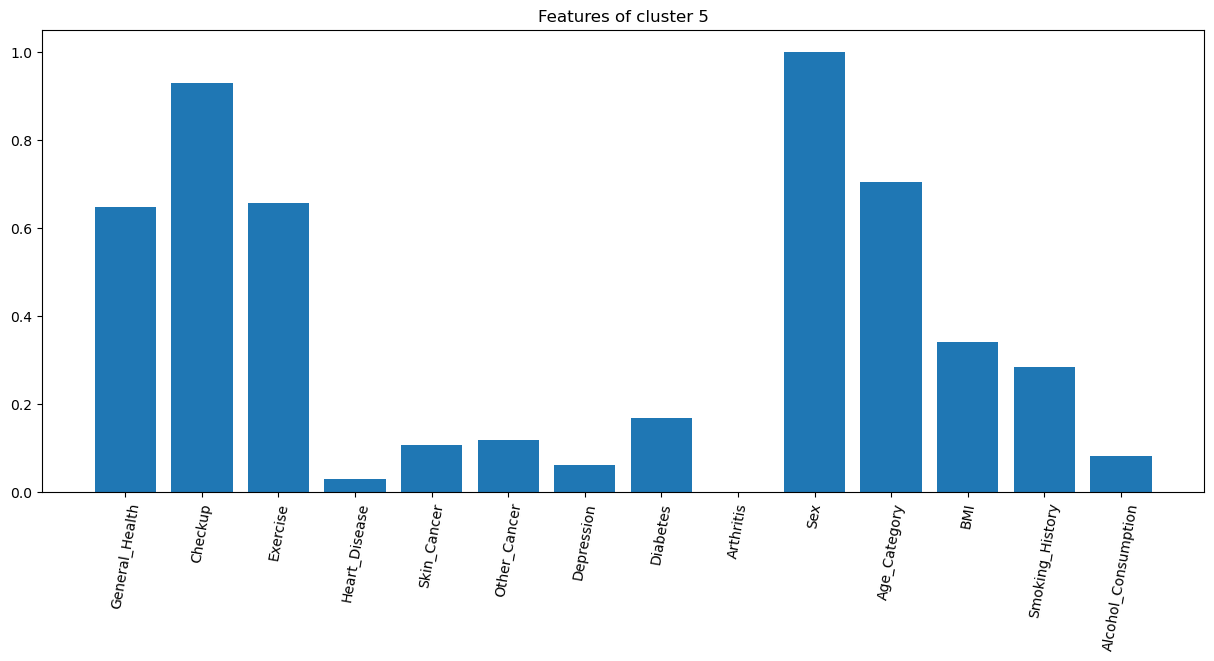

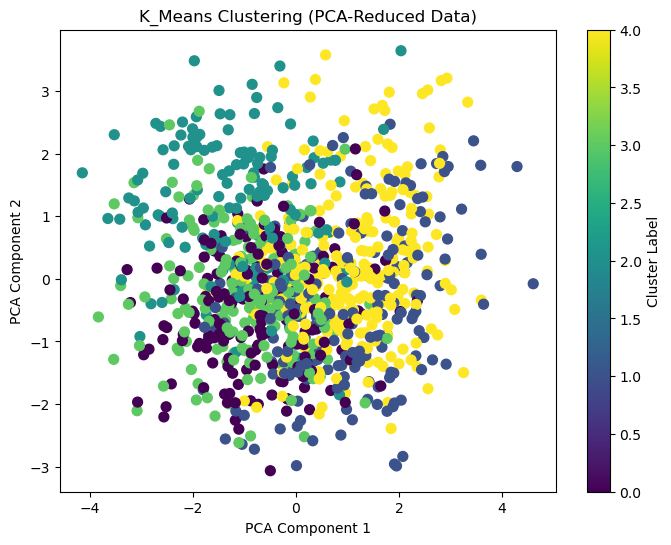

In [10]:
clusters = []
for i in range(0, max(data_kmeans['Cluster assignment']) + 1):
    clusters.append(np.mean(data_kmeans[data_kmeans['Cluster assignment'] == i], axis=0)[:-1])

for i in range(0, len(clusters)):
    plt.figure(figsize=(15, 6))
    plt.bar(clusters[i].index, clusters[i])
    plt.title(f"Features of cluster {i+1}")
    plt.xticks(rotation=80)  # Rotate the labels 45 degrees
    plt.show()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
X = np.array(scaled_data)
labels = data_kmeans['Cluster assignment']

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title("K_Means Clustering (PCA-Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Sex                    0.562265
General_Health         0.087417
Other_Cancer           0.029198
Age_Category           0.022203
Checkup                0.008857
BMI                   -0.027751
Diabetes              -0.030183
Exercise              -0.030912
Alcohol_Consumption   -0.050696
Skin_Cancer           -0.053902
Heart_Disease         -0.115998
Arthritis             -0.201037
Depression            -0.262028
Smoking_History       -0.438272
dtype: float64
4.5


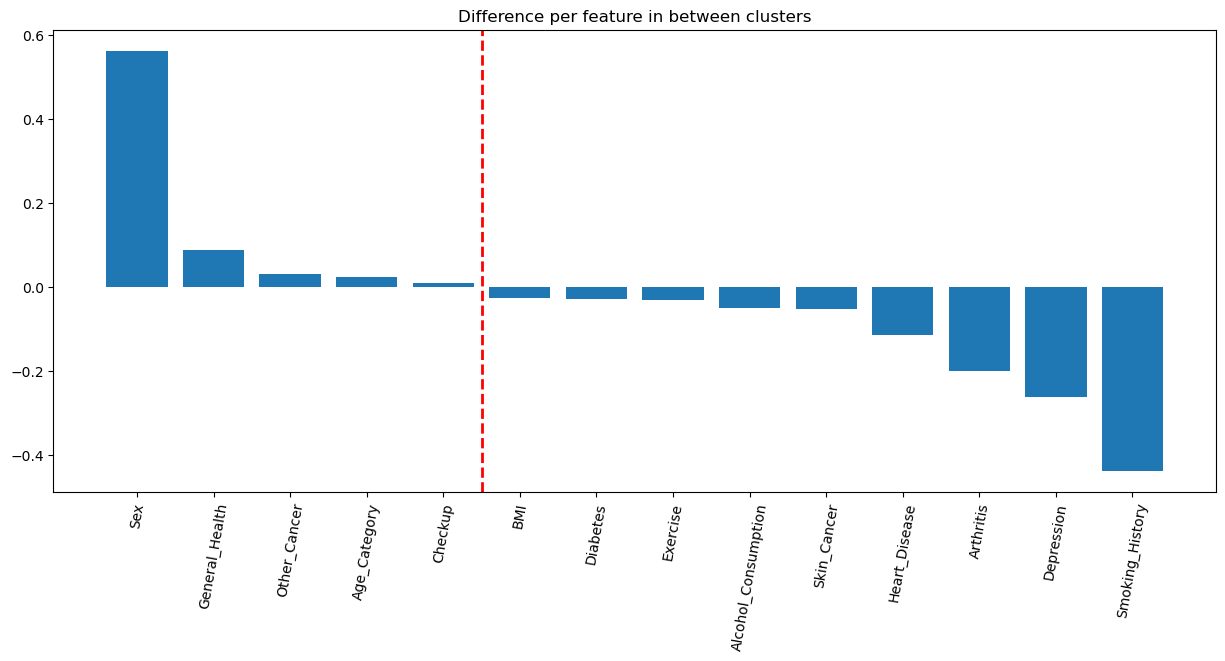

In [14]:
# only possible if k=2
# The optimal point for k seems to be k=3
kmeans = KMeans(n_clusters=2, random_state=13, n_init=10)
# Fit the model
kmeans.fit(data_kmeans)
# Get the cluster assignments
y_kmeans = kmeans.predict(data_kmeans)
data_kmeans['Cluster assignment'] = y_kmeans

clusters = []
for i in range(0, max(data_kmeans['Cluster assignment']) + 1):
    clusters.append(np.mean(data_kmeans[data_kmeans['Cluster assignment'] == i], axis=0)[:-1])

# get difference
s1, s2 = clusters    
difference = s2 -s1

difference = difference.sort_values(ascending=False)
print(difference)

x_position = list(difference.index).index("BMI")-0.5
print(x_position)
plt.figure(figsize=(15, 6))
plt.bar(difference.index, difference)
plt.axvline(x=x_position, color='red', linestyle='--', linewidth=2)
plt.title(f"Difference per feature in between clusters")
plt.xticks(rotation=80)  # Rotate the labels 45 degrees
plt.show()

In [15]:
# see correlations between clusters and heart disease
pd.crosstab(data_kmeans['Cluster assignment'], trainCrit)
#print(clusters, data_kmeans['Cluster assignment'])

Heart_Disease,0,1
Cluster assignment,,
0,416,102
1,443,39


In [16]:
scipy.stats.spearmanr(data_kmeans['Cluster assignment'], trainCrit).correlation   # Spearman's rho

-0.16654592538656254

In [17]:
dataKMeans = data.copy()
dataKMeans["KMeans_Cluster"] = data_kmeans['Cluster assignment']
summariesGrouped = dataKMeans.groupby("KMeans_Cluster").agg(["mean"])
summariesGrouped

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,BMI,Smoking_History,Alcohol_Consumption
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
KMeans_Cluster,,,,,,,,,,,,,,
0,2.959459,4.779923,0.613900,0.196911,0.194981,0.140927,0.297297,0.262548,0.613900,0.416988,66.328185,29.064170,0.604247,3.276062
1,3.309129,4.815353,0.582988,0.080913,0.141079,0.170124,0.035270,0.232365,0.412863,0.979253,67.682573,28.016577,0.165975,1.755187


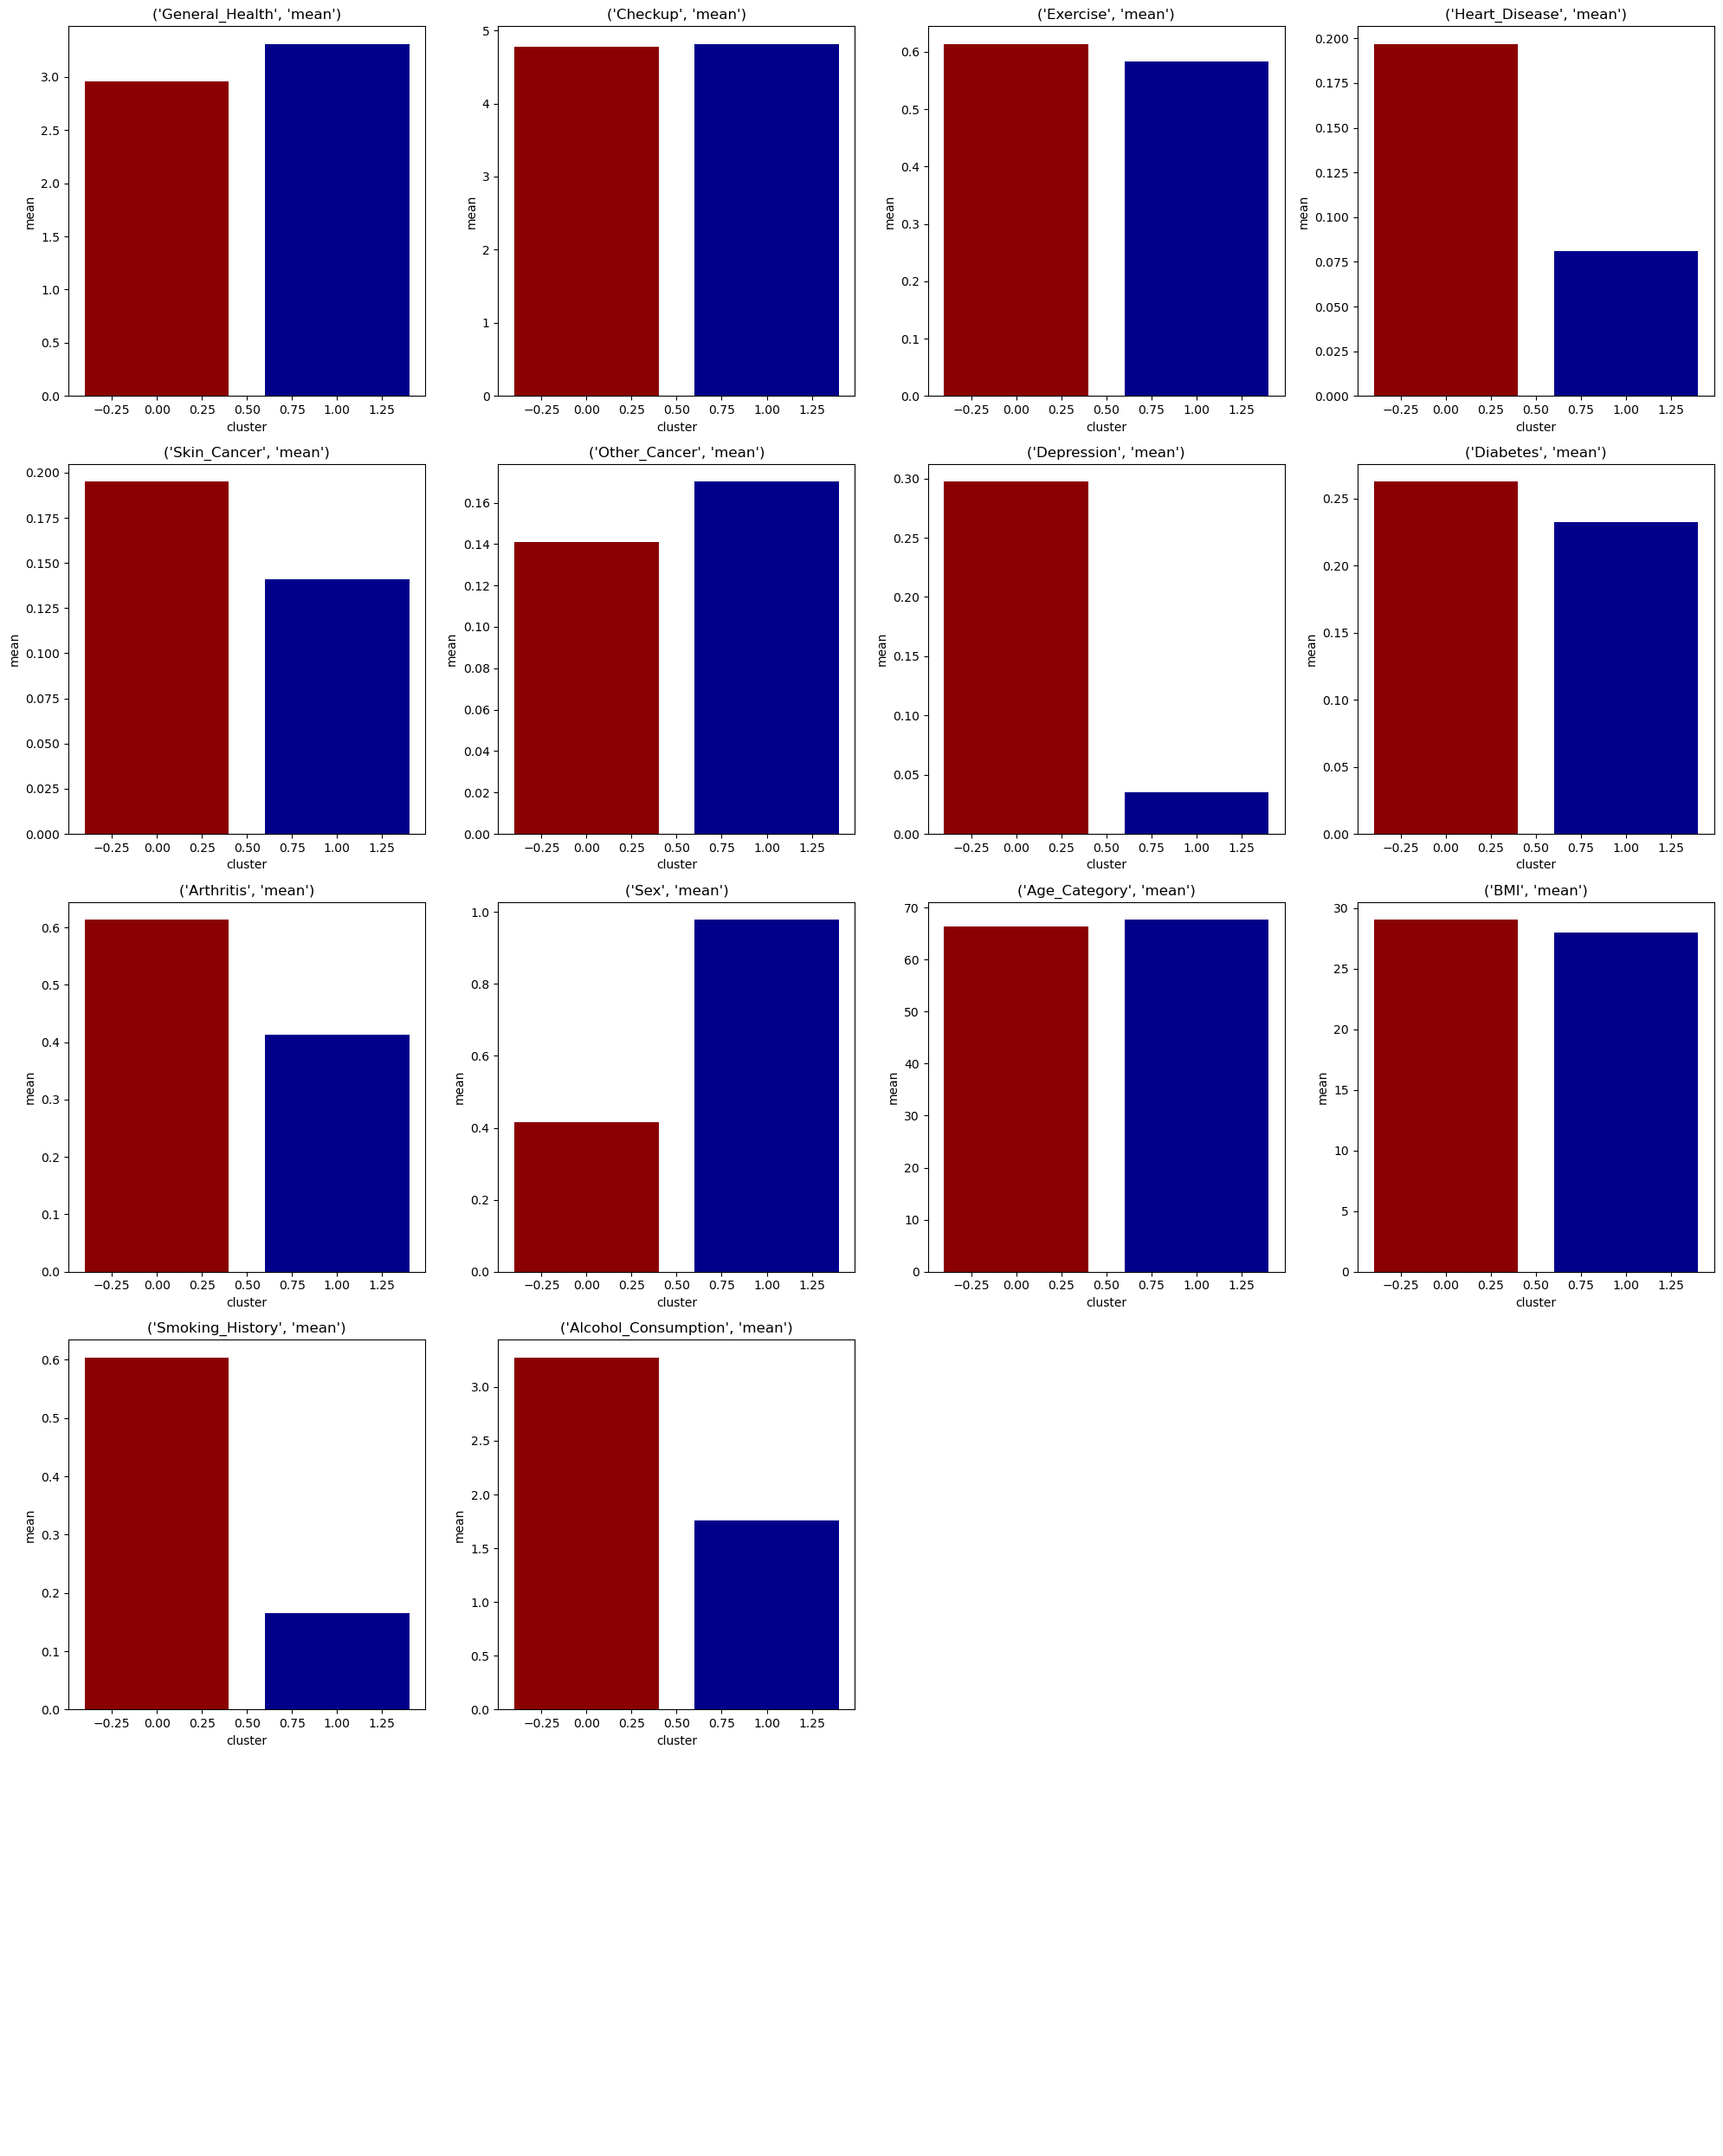

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))  
axes = axes.flatten()
for i, col in enumerate(summariesGrouped.columns):
    axes[i].bar(summariesGrouped.index[0], summariesGrouped[col].iloc[0], color='darkred')  # First bar
    axes[i].bar(summariesGrouped.index[1], summariesGrouped[col].iloc[1], color='darkblue')
    #axes[i].bar(summariesGrouped.index, summariesGrouped[col])  # Bar plot for each feature
    axes[i].set_title(col)  # Title for each subplot
    axes[i].set_xlabel('cluster')
    axes[i].set_ylabel('mean')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [19]:
# ???
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)
X_pca.shape

(1000, 2)

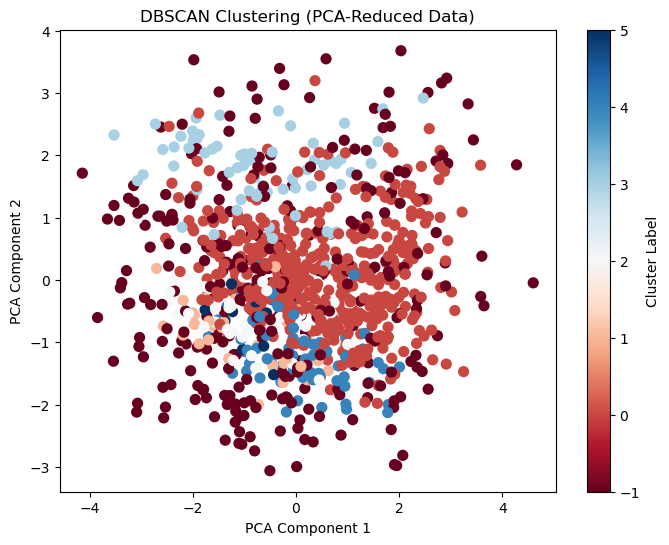

In [30]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
X = np.array(scaled_data)
#X, _ = make_blobs(n_samples=200, n_features=19, centers=3, random_state=42)

dbscan = DBSCAN(eps=2.5, min_samples=10)
labels = dbscan.fit_predict(X)
# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='RdBu', s=50)
plt.colorbar(label='Cluster Label')
plt.title("DBSCAN Clustering (PCA-Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [33]:
columnsNewOrder = ['Heart_Disease', 'Alcohol_Consumption', 'Other_Cancer', 'Skin_Cancer','Depression', 'Diabetes',
                   'Smoking_History',  'Arthritis',
                    'Sex', 'General_Health', 'Exercise', 'Checkup',   
                    'Age_Category', 'BMI', ]

In [34]:
dataOrder = data[columnsNewOrder]
dataOrder["DBSCAN_Cluster"] = labels
summariesGrouped = dataOrder.groupby("DBSCAN_Cluster").agg(["mean"])
summariesGrouped

/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_48391/4121235119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataOrder["DBSCAN_Cluster"] = labels


,Heart_Disease,Alcohol_Consumption,Other_Cancer,Skin_Cancer,Depression,Diabetes,Smoking_History,Arthritis,Sex,General_Health,Exercise,Checkup,Age_Category,BMI
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_Cluster,,,,,,,,,,,,,,
-1,0.333333,5.425170,0.309524,0.329932,0.346939,0.309524,0.517007,0.534014,0.564626,2.908163,0.557823,4.520408,66.363946,29.337483
0,0.000000,1.735808,0.000000,0.000000,0.000000,0.218341,0.314410,0.427948,0.718341,3.368996,0.650655,4.897380,65.960699,28.266878
1,1.000000,0.593750,0.000000,0.000000,0.000000,0.406250,0.875000,0.593750,0.218750,2.343750,0.687500,5.000000,69.656250,26.350313
2,0.000000,0.234375,1.000000,0.000000,0.000000,0.281250,0.218750,0.656250,0.875000,2.968750,0.421875,4.921875,74.109375,27.787969
3,0.000000,0.768116,0.000000,0.000000,1.000000,0.275362,0.478261,0.739130,0.942029,2.623188,0.507246,4.927536,60.463768,29.999275
4,0.000000,0.777778,0.000000,1.000000,0.000000,0.083333,0.305556,0.583333,0.763889,3.500000,0.611111,4.930556,73.666667,27.545694
5,1.000000,0.909091,0.000000,0.000000,0.000000,0.090909,0.000000,0.909091,0.909091,2.909091,0.818182,5.000000,73.818182,28.445455


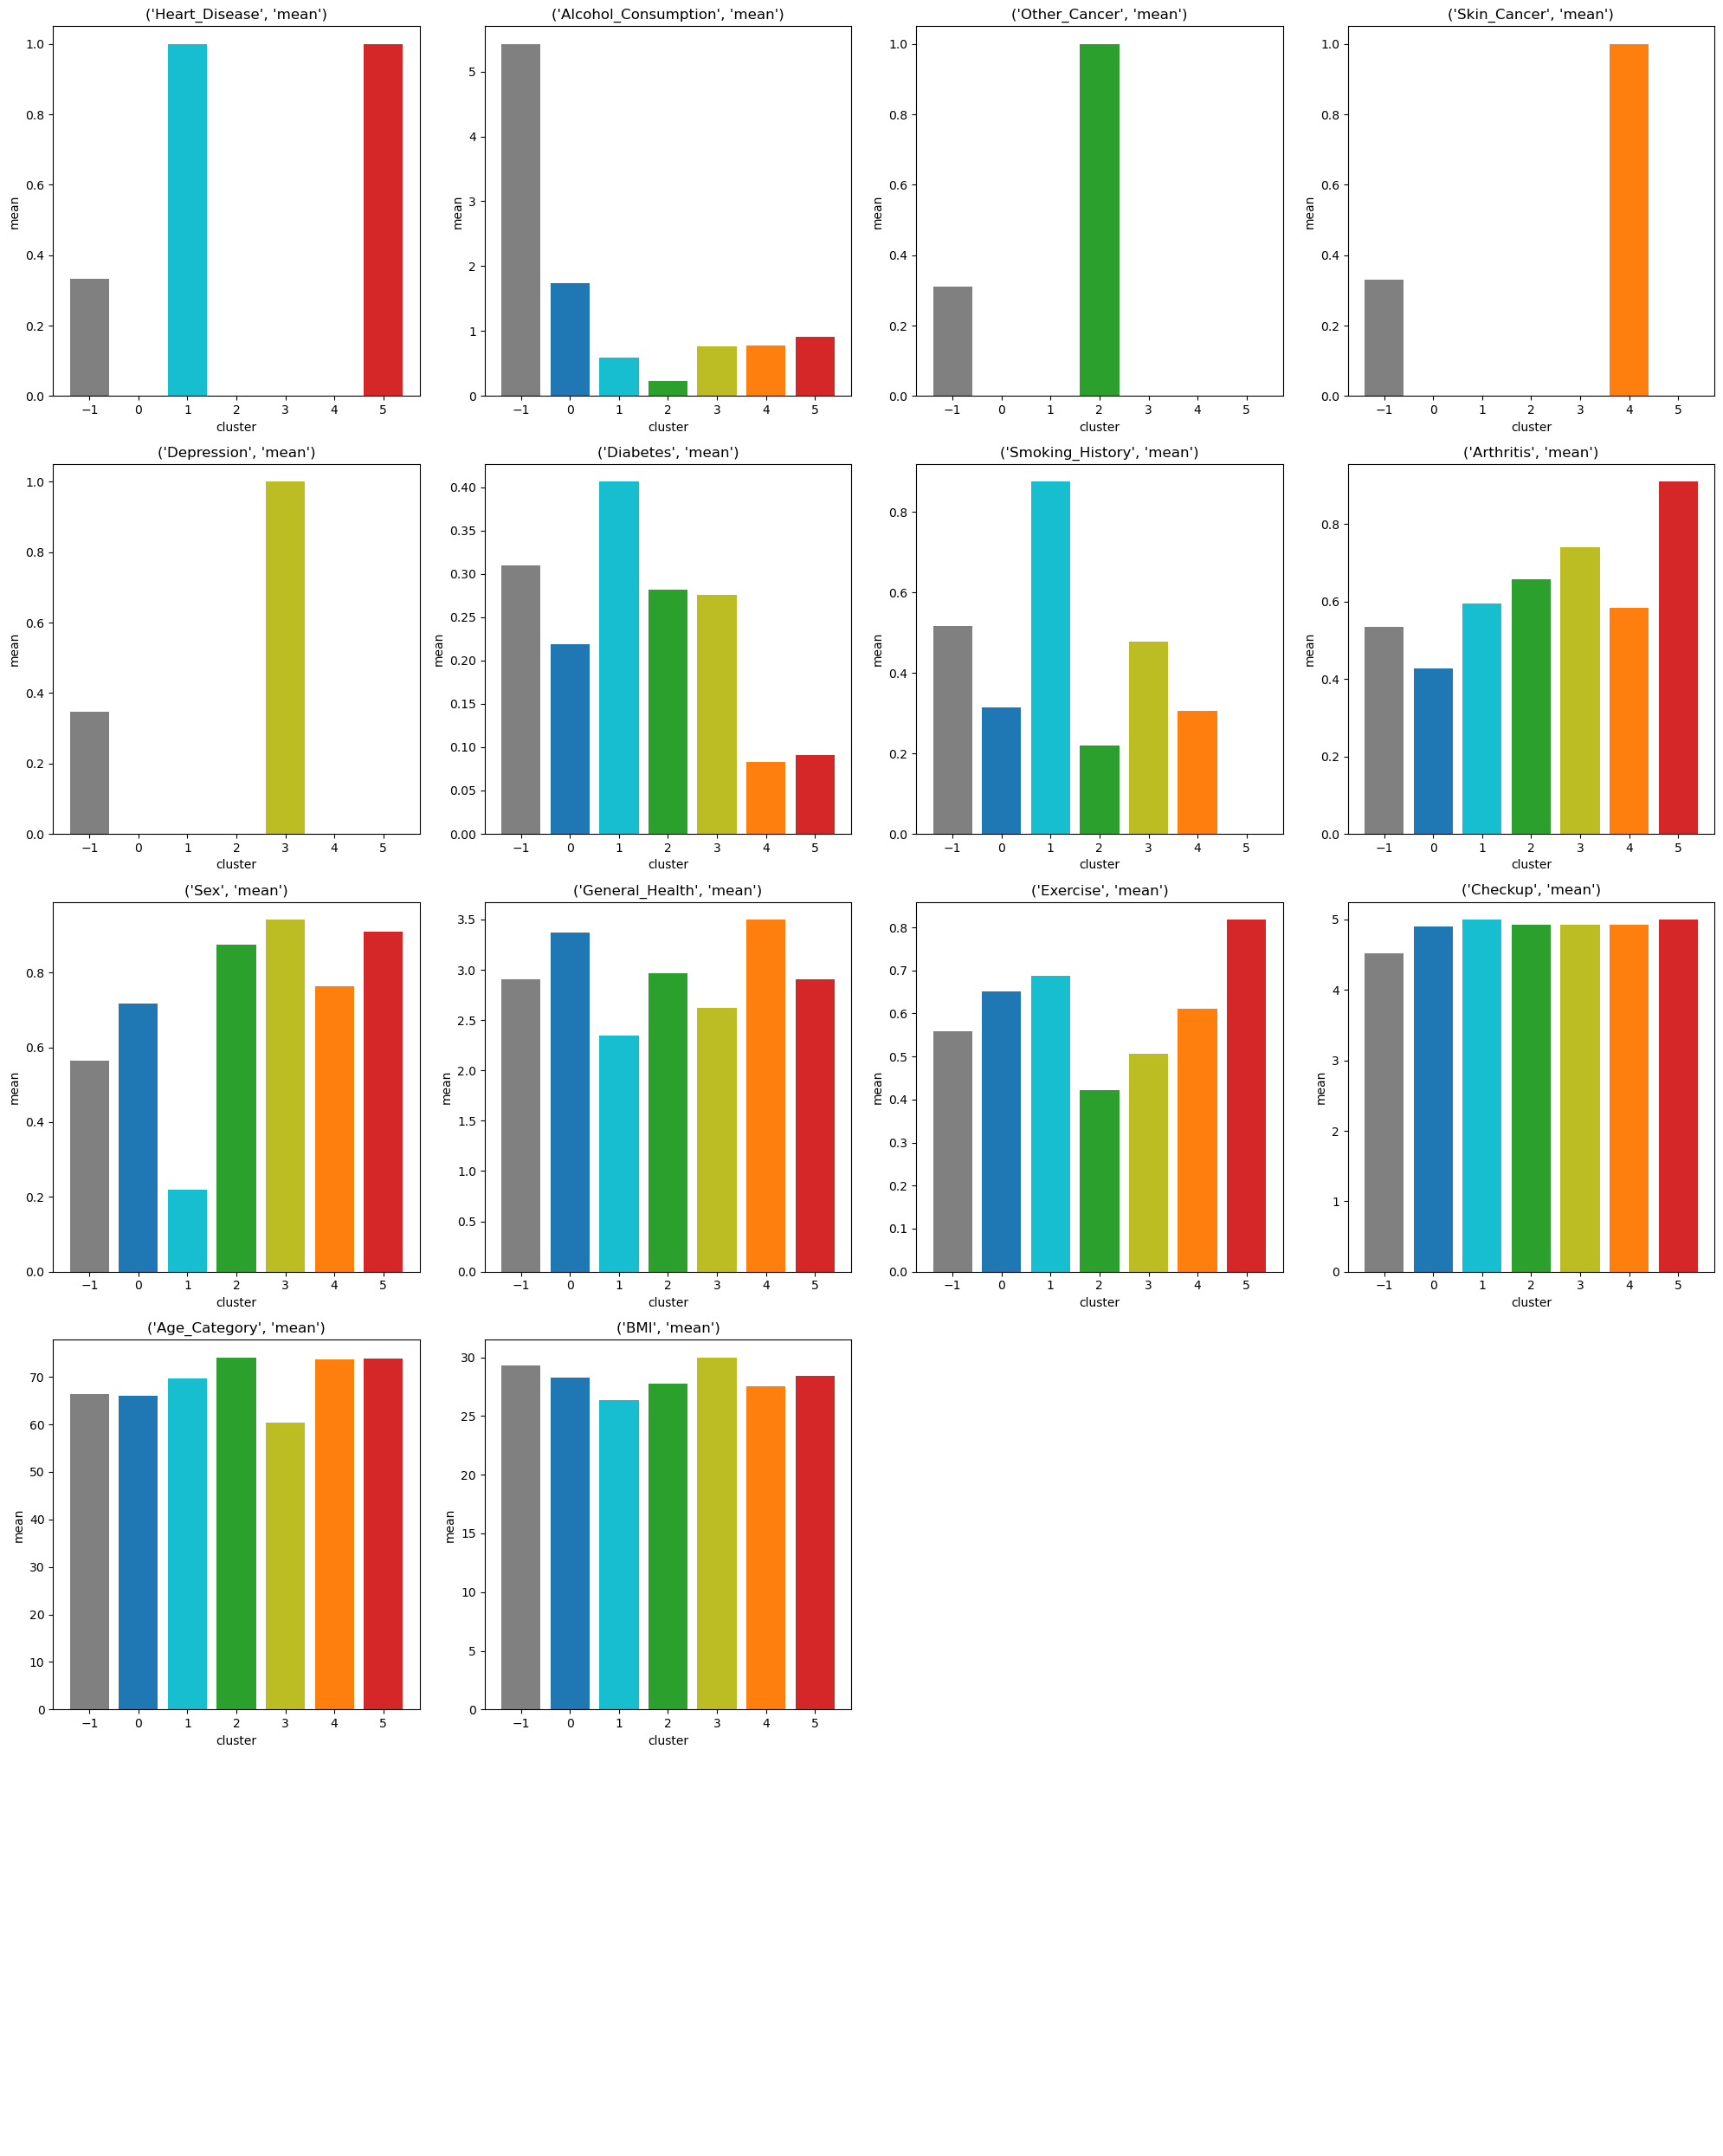

In [44]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))  
axes = axes.flatten()
for i, col in enumerate(summariesGrouped.columns):
    axes[i].bar(summariesGrouped.index[0], summariesGrouped[col].iloc[0], color='grey') 
    axes[i].bar(summariesGrouped.index[1], summariesGrouped[col].iloc[1], color='tab:blue')  
    axes[i].bar(summariesGrouped.index[2], summariesGrouped[col].iloc[2], color='tab:cyan')
    axes[i].bar(summariesGrouped.index[3], summariesGrouped[col].iloc[3], color='tab:green')  
    axes[i].bar(summariesGrouped.index[4], summariesGrouped[col].iloc[4], color='tab:olive') 
    axes[i].bar(summariesGrouped.index[5], summariesGrouped[col].iloc[5], color='tab:orange')  
    axes[i].bar(summariesGrouped.index[6], summariesGrouped[col].iloc[6], color='tab:red')  


    #axes[i].bar(summariesGrouped.index, summariesGrouped[col])  # Bar plot for each feature
    axes[i].set_title(col)  # Title for each subplot
    axes[i].set_xlabel('cluster')
    axes[i].set_ylabel('mean')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [198]:
pd.crosstab(labels, trainCrit)


Heart_Disease,0,1
row_0,,
-1,351,141
0,508,0


In [199]:
scipy.stats.spearmanr(labels, trainCrit).correlation   

-0.4116823795949804